Por: David Ángel Lozano García

# Algoritmo DQN (Deep Q-Networks)

En este ejercicio se ha entrenado una red neuronal dentro de la arquitectura del algoritmo DQN (Deepmind, 2015). Con este esquema, se abordará el entorno "Space Invaders" de Atari. Se considera que el ejercicio está resuelto si se obtiene finalmente una puntuación media superior a 20 puntos en 10 partidas en modo test.

## Preparación del entorno de trabajo

In [ ]:
# Se instalan las librerías que se van a utilizar.
!pip install gym &> /dev/null
!pip install gym[atari] &> /dev/null
!pip install h5py==2.10.0 &> /dev/null
!pip install jupyter &> /dev/null
!pip install Keras==2.2.4 &> /dev/null
!pip install keras-rl==0.4.2 &> /dev/null
!pip install Pillow &> /dev/null
!pip install tensorflow==1.13.1 &> /dev/null
!pip install torch &> /dev/null
!apt-get install -y xvfb python-opengl &> /dev/null
!pip install pyvirtualdisplay &> /dev/null
!pip install pyunpack  &> /dev/null


In [ ]:
# Conectamos con Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Se define un directorio base para guardar o cargar modelos.
directorio_base = "/content/drive/MyDrive/MIAR08_APR/"

Mounted at /content/drive


In [ ]:
# Se descargan los ROMS de Atari y se cargan en memoria.
# import wget
import os.path
import zipfile 

import urllib.request
# from patoolib import extract_archive

from pyunpack import Archive


url = 'http://www.atarimania.com/roms/Roms.rar'
ruta = os.path.join(directorio_base, "Roms.rar")


if not os.path.exists(ruta):
  print ("El archivo ROM se descargará en Google Drive.")
  rarfile= urllib.request.urlretrieve(url, ruta)
  os.mkdir(os.path.join(directorio_base, "roms"))
  Archive(ruta).extractall(os.path.join(directorio_base, "roms"))

else:
  print ("El archivo ROM ya existe en Google Drive.")




El archivo ROM ya existe en Google Drive.


In [ ]:
if not (os.path.isdir(os.path.join(directorio_base, "modelos"))):
  os.mkdir(os.path.join(directorio_base, "modelos"))

if not (os.path.isdir(os.path.join(directorio_base, "modelos", "logs"))):
    os.mkdir(os.path.join(directorio_base, "modelos", "logs"))

In [ ]:
!python -m atari_py.import_roms drive/MyDrive/MIAR08_APR/roms/ #&> /dev/null

copying atlantis.bin from drive/MyDrive/MIAR08_APR/roms/HC ROMS/BY ALPHABET/A-G/Atlantis.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/atlantis.bin
copying chopper_command.bin from drive/MyDrive/MIAR08_APR/roms/HC ROMS/BY ALPHABET/A-G/Chopper Command.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/chopper_command.bin
copying breakout.bin from drive/MyDrive/MIAR08_APR/roms/HC ROMS/BY ALPHABET/A-G/Breakout - Breakaway IV.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/breakout.bin
copying boxing.bin from drive/MyDrive/MIAR08_APR/roms/HC ROMS/BY ALPHABET/A-G/Boxing.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/boxing.bin
copying freeway.bin from drive/MyDrive/MIAR08_APR/roms/HC ROMS/BY ALPHABET/A-G/Freeway.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/freeway.bin
copying bank_heist.bin from drive/MyDrive/MIAR08_APR/roms/HC ROMS/BY ALPHABET/A-G/Bank Heist.bin to /usr/local/lib/python3.7/dist-pac

### Funciones importantes

In [ ]:
# Definición de una función que crea un vídeo a partir de una serie de fotogramas.
def crear_video(fotogramas, nombre_video):
  objeto_video = cv2.VideoWriter(filename = "Temporal.mp4",
                                 fourcc = cv2.VideoWriter_fourcc(*'XVID'),
                                 fps = 20.0,
                                 frameSize = (fotogramas[0].shape[1], fotogramas[0].shape[0]),
                                 isColor = True) 
  
  for imagen in fotogramas:
    objeto_video.write(cv2.cvtColor(imagen, cv2.COLOR_RGB2BGR))
  
  objeto_video.release()

  os.system(f"ffmpeg -y -i Temporal.mp4 -vcodec h264 '{nombre_video}'.mp4")

In [ ]:
# Código necesario para que el render funcione en juegos que no son de Atari (como CartPole).
from pyvirtualdisplay import Display
display = Display(visible = 0, size = (400, 300))
display.start();

In [ ]:
# Función que calcula épsilon a partir de los valores de configuracion y los trained steps
def get_epsilon (steps, value_max, value_min, nb_steps):
  a = -float(value_max - value_min) / float(nb_steps)
  b = float(value_max)
  value = max(value_min, a * float(steps) + b)
  return value

### Callbacks

In [ ]:
from keras.callbacks import Callback                 

# Definición de un callback que permite guardar los fotogramas obtenidos del render durante cada episodio y crea un vídeo con ellos.
class Visualizer(Callback):
    def __init__(self):
        super(Visualizer, self).__init__()
        # Se crea una lista vacía para almacenar los fotogramas de cada episodio.
        self.fotogramas = []
    
    def _set_env(self, env):
        self.env = env
    
    def on_action_end(self, action, logs):
        # Se añade un nuevo fotograma a la lista.
        self.fotogramas.append(self.env.render(mode = "rgb_array"))
    
    def on_episode_end(self, episode, logs={}):
        # Se crea el vídeo del episodio actual y se borran los fotogramas utilizados.
        crear_video(self.fotogramas, "Partida " + str(episode + 1))
        self.fotogramas = []

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [ ]:
import tensorflow as tf

# Definición de un callback que almacena en un archivo json el número de steps entrenados hasta el momento

# Enlaces útiles:
# Documentación de keras: https://www.tensorflow.org/guide/keras/custom_callback 
# Implementacion de las callbacks (para ver como funcionan por dentro): https://github.com/keras-rl/keras-rl/blob/master/rl/callbacks.py

class TrainedStepsLogger (tf.keras.callbacks.Callback):
    def __init__(self, filepath, interval, trained_steps, verbose=0):
        self.filepath = filepath
        self.interval = interval
        self.verbose = verbose
        self.total_steps = 0
        self.trained_steps = trained_steps

    def save_data(self):
      print (f"**\n INFO: Grabando en archivo trained_steps = : {self.trained_steps + self.total_steps}")

      ts_dict = {}
      ts_dict['ts'] = int (self.trained_steps + self.total_steps)

      with open(self.filepath, 'w') as f:
            json.dump(ts_dict, f)

    def on_step_end(self, step, logs={}):
        """ Save weights at interval steps during training """
        # print (f"** INFO self.total_steps      ... {self.total_steps}")
        self.total_steps += 1
        # print (f"** INFO self.total_steps += 1 ... {self.total_steps}")

        if self.total_steps % self.interval != 0:
            # Nothing to do.
            return
        else:
            self.save_data()


## Ejemplo de DQN con SpaceInvaders

### Carga de librerías

In [ ]:
import cv2
import os
import gym
from keras.models import Sequential
from keras.layers import Permute, Convolution2D, Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from rl.memory import SequentialMemory 
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
import numpy as np
from rl.core import Processor
from PIL import Image
from rl.agents.dqn import DQNAgent
from rl.callbacks import ModelIntervalCheckpoint, FileLogger
from ipywidgets import Video                                                # Para reproducir un vídeo creado con los fotogramas de una partida.

import glob
import json


### Creación del entorno donde el agente se ejecutará

In [ ]:
# Se crea un entorno de Breakout.
nombre_entorno = 'SpaceInvaders-v0'

env = gym.make(nombre_entorno)
env.seed(123)

# Se obtiene el número de acciones disponibles en el entorno.
num_acciones = env.action_space.n

### Definición de componentes del agente
Se ha utilizado un base model de tres bloques convolucionales, y un top model formado por dos capas densas que disminuyen la dimensionalidad gradualmente (1024 y 32 neuronas, respectivamente) que conectan con una capa final de tantas salidas como movimientos posibles puede realizar el agente (6).

Se han realizado pruebas con distintas parametrizaciones y mecanismos de normalización (batch normalization y dropout). No obstante, los mejores resultados se han obtenido sin ellos, por lo que esas líneas de código se han dejado en modo comentario.


In [ ]:
# Red neuronal que modelará la función Q.
dim_finales_observaciones = (84, 84)
longitud_ventana = 4
dimensiones_entrada = (longitud_ventana,) + dim_finales_observaciones

modelo_Q = Sequential()

# Se añade una capa que realiza una permutación a las dimensiones de entrada, situando los canales como última dimensión.
modelo_Q.add(Permute((2, 3, 1), input_shape = dimensiones_entrada))

# BASE MODEL

modelo_Q.add(Convolution2D(32, (8,8), strides=(4,4)))
# modelo_Q.add(BatchNormalization())
modelo_Q.add(Activation('relu'))
# modelo_Q.add(Dropout(0.1))

modelo_Q.add(Convolution2D(64, (4,4), strides=(2, 2)))
# modelo_Q.add(BatchNormalization())
modelo_Q.add(Activation('relu'))
# modelo_Q.add(Dropout(0.1))

modelo_Q.add(Convolution2D(64, (3,3), strides=(1, 1)))
# modelo_Q.add(BatchNormalization())
modelo_Q.add(Activation('relu'))
# modelo_Q.add(Dropout(0.1))


# TOP MODEL
modelo_Q.add(Flatten())
# modelo_Q.add(Dense(512, activation = "relu"))
# modelo_Q.add(Dense(num_acciones, activation = "linear"))

modelo_Q.add(Dense(1024))
# modelo_Q.add(BatchNormalization())
modelo_Q.add(Activation('relu'))
modelo_Q.add(Dense(32))
# modelo_Q.add(BatchNormalization())
modelo_Q.add(Activation('relu'))
modelo_Q.add(Dense(num_acciones))
# modelo_Q.add(BatchNormalization())
modelo_Q.add(Activation('linear'))
# modelo_Q.add(Dropout(0.1))

print(modelo_Q.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
acti

Dado que los entrenamientos son bastante largos, en las siguientes celdas se prepara el sistema para su recuperación en caso de que exista un entrenamiento previo interrumpido. En tal caso, se recupera el archivo de pesos más reciente y se carga en el agente. Asimismo, se corrige la policy, actualizando épsilon al valor adecuado.

In [ ]:

# 1. detectar si hay un entrenamiento previo incompleto y obtener el último archivo de pesos
latest_weight_file = None
list_of_files = glob.glob(os.path.join(directorio_base, "modelos", "*.h5f" )) 
if (len(list_of_files)>0):
  latest_weight_file = max(list_of_files, key=os.path.getctime)
  print ("Localizando el último archivo de pesos almacenado.")
  print(latest_weight_file)
else:
  print ("No hay ningún archivo de pesos almacenado.")


Localizando el último archivo de pesos almacenado.
/content/drive/MyDrive/MIAR08_APR/modelos/dqn_SpaceInvaders-v0_weights.h5f


In [ ]:
# 2. Recuperar el número de pasos entrenados a partir del fichero json

# ruta_ts_json = os.path.join(directorio_base, "modelos", "trained_steps_{}_log.json".format(nombre_entorno) )
ruta_ts_json = directorio_base+"modelos/logs/"+"trained_steps_{}_log.json".format(nombre_entorno) 
if not os.path.exists(ruta_ts_json):
  trained_steps = 0
else:
  # Opening JSON file
  f = open(ruta_ts_json)
  
  # returns JSON object as a dictionary
  data = json.load(f)

  # Recuperar los pasos entrenados
  trained_steps = data ['ts'] 
  print (f"** INFO: Se ha recuperado trained_steps = {trained_steps}")   
  
  # Closing file
  f.close()



** INFO: Se ha recuperado trained_steps = 8000000


In [ ]:
# 3. Parametrización del periodo de actualización del modelo
UPDATE_PERIOD = 10000

In [ ]:
# 4. Actualizar el valor de epsilon
value_max = 1
value_min = 0.1
nb_steps_annealed = 100 * UPDATE_PERIOD
new_max_epsilon = get_epsilon (trained_steps, value_max, value_min, nb_steps_annealed)
print (new_max_epsilon)

0.1


In [ ]:
# 5. Definición de la memoria y la policy.

memoria = SequentialMemory(limit=1000000, window_length=longitud_ventana)

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=new_max_epsilon, value_min=value_min, value_test=.05,
                              nb_steps= max (1,nb_steps_annealed - trained_steps)) 

In [ ]:
# 6. Procesador para realizar el preprocesamiento de las observaciones, y normalización de estados y recompensas.
np.random.seed(123)

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3
        
        img = Image.fromarray(observation)
        img = img.resize(dim_finales_observaciones).convert('L')

        processed_observation = np.array(img)

        assert processed_observation.shape == dim_finales_observaciones

        return processed_observation.astype("uint8")
    
    def process_state_batch(self, batch):
        return batch.astype("float32") / 255.
    
    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

procesador = AtariProcessor()

A continuación se define y compila el agente en sí, que incluye la red neuronal ya creada. Como tasa de aprendizaje opto por 0.0001, ya que valores mayores han dado algunos problemas de convergencia.

In [ ]:
# 7. Compilación del agente
modelo_agente_DQN = DQNAgent(model = modelo_Q,
                             nb_actions = num_acciones,
                             memory = memoria,
                             policy = policy,
                             processor = procesador,
                             nb_steps_warmup = 50000,
                             gamma = 0.99,
                             target_model_update = UPDATE_PERIOD, 
                             train_interval = 25)

modelo_agente_DQN.compile(Adam(lr = 0.0001), metrics = ["mae"])


In [ ]:

# 8. Carga del último archivo de pesos guardado en caso de existir un entrenamiento ya comenzado
if (trained_steps !=0):

  modelo_agente_DQN.load_weights(os.path.join(directorio_base, 'modelos', latest_weight_file)  )
  print (f"Se ha cargado el archivo de pesos más reciente: {os.path.join(directorio_base, 'modelos', latest_weight_file)}")


Se ha cargado el archivo de pesos más reciente: /content/drive/MyDrive/MIAR08_APR/modelos/dqn_SpaceInvaders-v0_weights.h5f


### Entrenamiento del modelo del agente

In [ ]:
# Se definen callbacks para guardar los pesos durante el entrenamiento y para guardar informes en formato JSON.
weights_filename = directorio_base+'modelos/dqn_{}_weights.h5f'.format(nombre_entorno)
model_checkpoint = ModelIntervalCheckpoint(directorio_base+"modelos/dqn_" + nombre_entorno + "_weights_{step}.h5f", interval = (UPDATE_PERIOD *25) ) 

json_logger = FileLogger(directorio_base+"modelos/logs/dqn_"+nombre_entorno+"_log.json", interval = UPDATE_PERIOD)

ts_logger = TrainedStepsLogger (os.path.join(directorio_base, "modelos", "logs", "trained_steps_{}_log.json".format(nombre_entorno), ), interval = (UPDATE_PERIOD *25), trained_steps=trained_steps)


# Entrenamiento del modelo

Se ha entrenado el modelo durante 8 millones de steps. Es un periodo más que de sobra, como queda ilustrado en las gráficas que se acompañan al final del notebook. El entrenamiento ha durado 78721.826 segundos, es decir casi 22 horas.

In [ ]:

training_steps = 8000000
modelo_agente_DQN.fit(env, nb_steps = training_steps - trained_steps , callbacks = [model_checkpoint, json_logger, ts_logger], verbose = 1, log_interval = UPDATE_PERIOD)
modelo_agente_DQN.save_weights(weights_filename, overwrite=True)


Training for 8000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 51s 5ms/step - reward: 0.0150
13 episodes - episode_reward: 11.077 [3.000, 20.000] - ale.lives: 2.203

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 51s 5ms/step - reward: 0.0127
15 episodes - episode_reward: 8.267 [2.000, 17.000] - ale.lives: 2.064

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 51s 5ms/step - reward: 0.0129
16 episodes - episode_reward: 8.312 [3.000, 19.000] - ale.lives: 2.170

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 49s 5ms/step - reward: 0.0124
15 episodes - episode_reward: 8.600 [3.000, 17.000] - ale.lives: 2.117

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 50s 5ms/step - reward: 0.0133
15 episodes - episode_reward: 8.400 [2.000, 15.000] - ale.lives: 2.070

Interval 6 (50000 steps performed)
   20/10000 [....

# Evaluación del modelo del agente

A continuación se evalúa el comportamiento de nuestro agente entrenado. En primer lugar, se incorporan unas gráficas obtenidas a partir de los datos almacenados en el archivo log que ilustran la evolución de los principales indicadores durante el entrenamiento. Finalmente, se realizará una prueba de test como indica el enunciado del problema, debiéndose obtener una puntuación superior a 20.

### Gráficas de evolución del entrenamiento

In [ ]:
# 1. Acceso al archivo json
directorio_base+"modelos/logs/dqn_"+nombre_entorno+"_log.json"
jsonfile_path = os.path.join (directorio_base, 'modelos','logs','dqn_'+nombre_entorno+'_log.json')
with open(jsonfile_path) as file:
    data = json.load(file)


In [ ]:
# 2. Carga del archivo json en memoria
import pandas as pd
from IPython.display import display

df = pd.DataFrame.from_dict(data).set_index('episode')

display(df.sample(5))

,loss,mean_absolute_error,mean_q,mean_eps,episode_reward,nb_episode_steps,nb_steps,duration
episode,,,,,,,,
9246,0.013494,2.620477,3.148870,0.1,26.0,1117,7699624,11.659759
4762,0.013340,2.380187,2.871826,0.1,18.0,822,3702493,8.010529
8477,0.018807,2.792442,3.365191,0.1,35.0,1317,7008235,12.631085
8170,0.020808,2.738244,3.294727,0.1,2.0,442,6733433,4.351632
2642,0.008116,1.878448,2.268282,0.1,12.0,820,1910881,8.177868


Para visualizar los datos, se define la siguiente función *plot_column*, que toma como entrada el dataframe obtenido a partir del log, el nombre del dato a visualizar (columna del dataframe), y una ventana, que será un periodo sobre el cual hacer promedio, con el fin de visualizar una runnning average y representar curvas más suaves que recojan mejor la tendencia de los datos.

En los apartados siguientes, se analizarán cada una de las curvas de valores medios obtenidos.

In [ ]:
import matplotlib.pyplot as plt

def plot_column (df, columna, ventana):
  x = df.index
  y = df [columna]

  average_y = []
  window = ventana
  for ind in range(len(y) - window + 1):
    average_y.append(np.mean(y[ind:ind+window]))

  for ind in range(window - 1):
    average_y.insert(0, np.nan)

  plt.figure(figsize=(16, 8))
  plt.plot(x, y, 'b.-', label='Original data')
  plt.plot(x, average_y, 'r.-', label='Running average')
  plt.grid(linestyle='solid')
  plt.ylabel(columna)
  plt.xlabel('episode')
  
  # plt.yticks([-1, -0.5, 0, 0.5, 1])
  plt.grid(linestyle=':')
  plt.legend()
  plt.show()


#### Evolución de la episode_reward
La primera de las gráficas representa la evolución de la recompensa media obtenida por episodio a lo largo del entrenamiento.

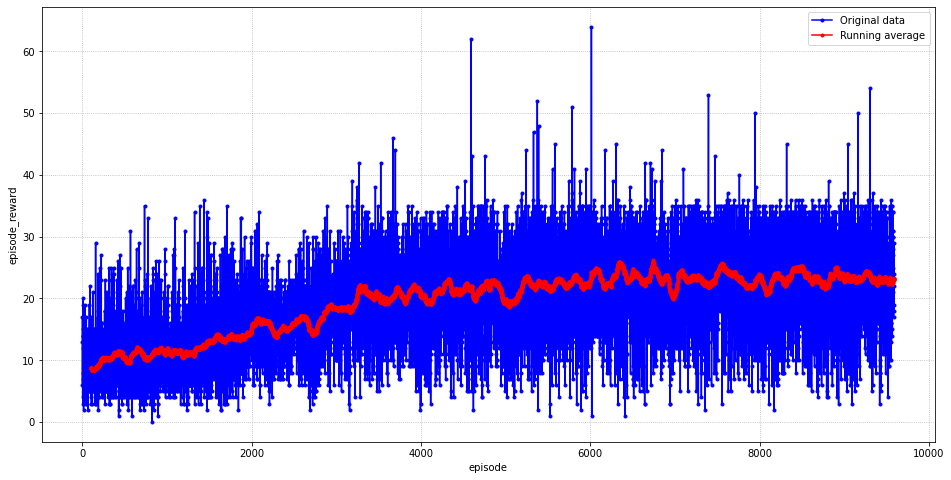

In [ ]:

plot_column (df, 'episode_reward', 100)


Se observa que durante aproximadamente los primeros 3000 episodios la tendencia es más o menos constante y bastante clara en sentido ascendente. A partir de ese punto, la pendiente cae hasta llegar a los 6000 episodios, donde la curva parece estancarse en un valor más o menos constante hasta los 10000 episodios. 

#### Evolución de la duración media por episodio
En la segunda gráfica se representa la evolución de la duración media por episodio durante el entrenamiento.

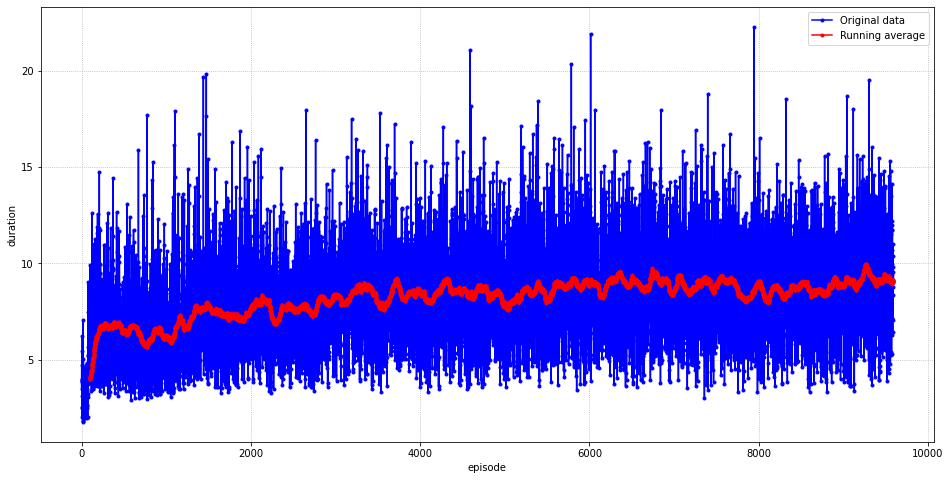

In [ ]:
plot_column (df, 'duration', 100)

Esta curva no presenta muchas sospresas: la duración del episodio crece muy rápido al principio y queda estancada en un valor más o menos constante en torno a los 4000 episodios.

#### Evolución del valor medio del Q-value estimado

En la tercera gráfica se representa la evolución del valor medio del Q-value estimado por episodio durante el entrenamiento.

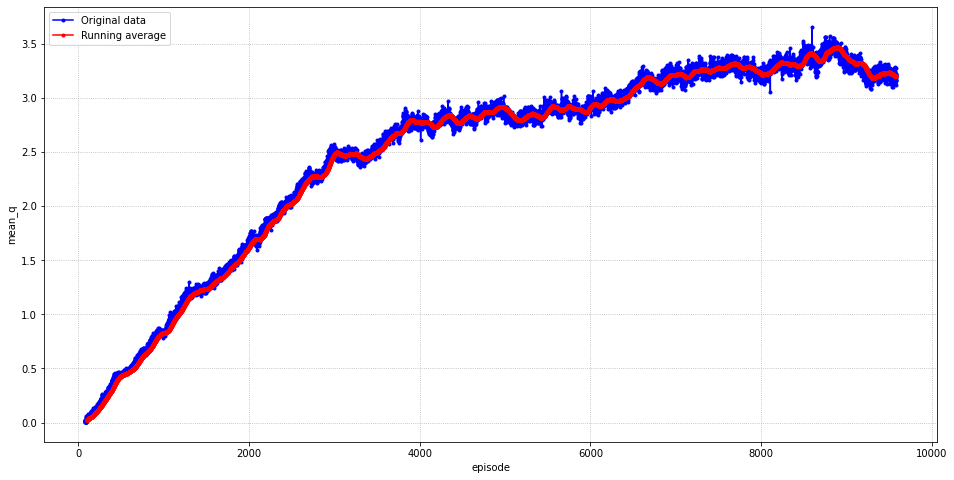

In [ ]:
plot_column (df, 'mean_q', 100)

Esta gráfica es muy interesante porque se intuye cierta correlación con la primera gráfica. De nuevo observamos cómo la media del Q-value crece de forma clara hasta más o menos los 4000 episodios, para de ahi en adelante crecer más lentamente (e incluso decae unas décimas al final del entrenamiento).

#### Evolución del valor medio de la pérdida por episodio
En esta gráfica se representa la evolución del valor medio de la pérdida por episodio durante el entrenamiento.

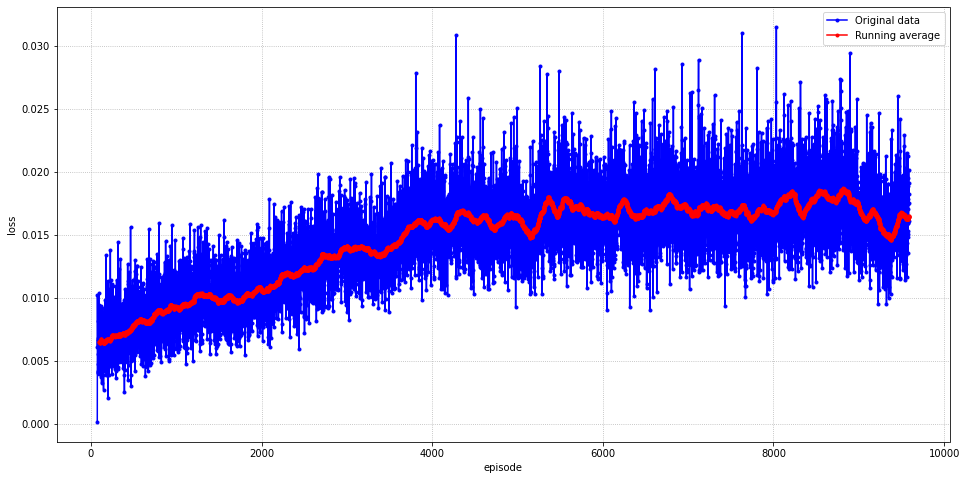

In [ ]:
plot_column (df, 'loss', 100)

De nuevo se aprecia la tendencia creciente de este parámetro hasta los 4000 episodios, oscilando en un valor algo por encima de 0.15 a partir de entonces.

#### Evolución del valor medio de épsilon

En la siguiente gráfica se muestra la evolución del valor medio de épsilon durante el entrenamiento.

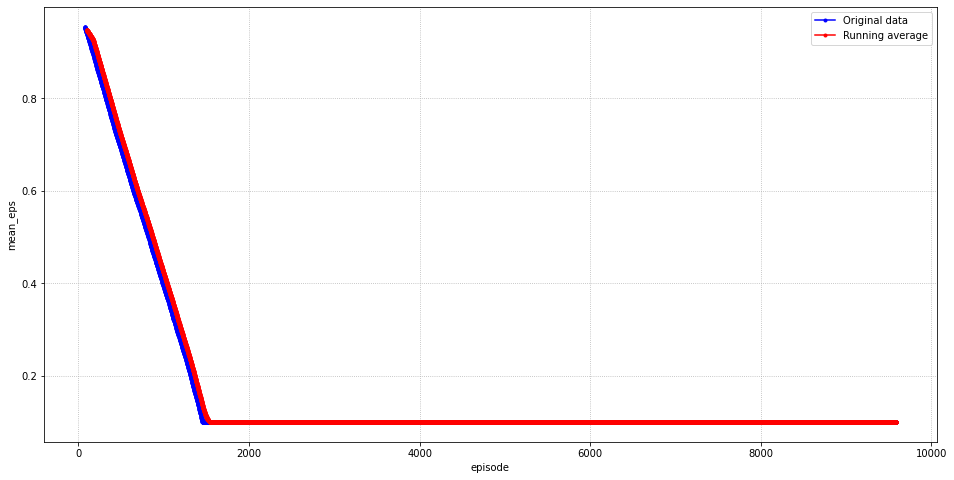

In [ ]:
plot_column (df, 'mean_eps', 100)

Como sabíamos, decae linealmente hasta alcanzar un valor mínimo de 0.1, permaneciendo constante desde entonces.

### Análisis de las gráficas
A raíz de las curvas anteriores, mis conclusiones son las siguientes: en presencia de un épsilon fuerte, el aprendizaje es más rápido (es lógico al principio, cuando el agente tiene mucho que aprender). Esto se debe a que la toma de decisiones aleatorias, a veces exitosas, va introduciendo mejoras en el comportamiento del modelo.

Al desvanecerse épsilon, en torno a los 1500 episodios, el aprendizaje aún mantiene una tendencia al alza, lo cual se aprecia en las gráficas de episode_reward y de mean_q, debido a la influencia de las transiciones aleatorias que aún permanecen en la memoria: épsilon se desvanece en 1000000 steps y la memoria tiene ese mismo tamaño, con lo cual tras el desvanecimiento de épsilon su influencia se deja sentir 1000000 steps más. Lo cual concuerda con los cambios de tendencia de las curvas episode_reward y mean_q en torno a los 4000 episodios (quizá un poco antes) ya señalados anteriormente.

En definitiva, el entrenamiento más allá del punto en el que épsilon alcanza su mínimo y posteriormente se alcanza el tamaño de la memoria es bastante improductivo, estancándose los valores de la recompensa y la estimación del Q-value.

Probablemente, se obtendrían mejores resultados con una parametrización en la que épsilon decayera más lentamente, hasta casi el final del entrenamiento. No obstante, el entrenamiento realizado es suficiente para cumplir con el objetivo marcado en el enunciado del ejercicio, como se muestra a continuación.


# Evaluación del modelo entrenado
A continuación se evalúa el modelo en 10 iteraciones en modo test. Los resultados se almacenan en un objeto de tipo keras.callbacks.History, que utilizaremos posteriormente para extraer las puntuaciones y obtener el valor medio.

In [ ]:
# Testing part to calculate the mean reward
res_test = modelo_agente_DQN.test(env, nb_episodes=10, visualize=False,callbacks = [Visualizer()])

Testing for 10 episodes ...
Episode 1: reward: 28.000, steps: 705
Episode 2: reward: 21.000, steps: 665
Episode 3: reward: 29.000, steps: 1047
Episode 4: reward: 27.000, steps: 882
Episode 5: reward: 27.000, steps: 858
Episode 6: reward: 33.000, steps: 1125
Episode 7: reward: 21.000, steps: 716
Episode 8: reward: 35.000, steps: 1090
Episode 9: reward: 25.000, steps: 856
Episode 10: reward: 37.000, steps: 1237


En la siguiente celda se visualiza la mejor partida.

In [ ]:
def get_best_play (history):
  max_score = max (history.history['episode_reward'])
  return history.history['episode_reward'].index(max_score) +1

mejor_partida = get_best_play (res_test)

Video.from_file(f"Partida {mejor_partida}.mp4", width = 300)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03\xec\x95mdat\x0…

In [ ]:
# Función auxiliar para calcular la media de las puntuaciones almacenadas en un objeto keras.callbacks.History
def get_mean_reward(history):
  mean_reward = 0
  for reward in history.history['episode_reward']:
    mean_reward += reward
  
  return mean_reward / len (history.history['episode_reward'])

# res_tes.history
print (f"La puntuación media obtenida es : {get_mean_reward(res_test)}")

La puntuación media obtenida es : 28.3
